# Elasticsearch Synonym Filters
The following files explains the approach used to build up an Elasticsearch synonym filter file from the SOAM data structure (see file 0.1.1 regarding the SOAM data structure)

https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-synonym-tokenfilter.html

#### Very Base Requirements 
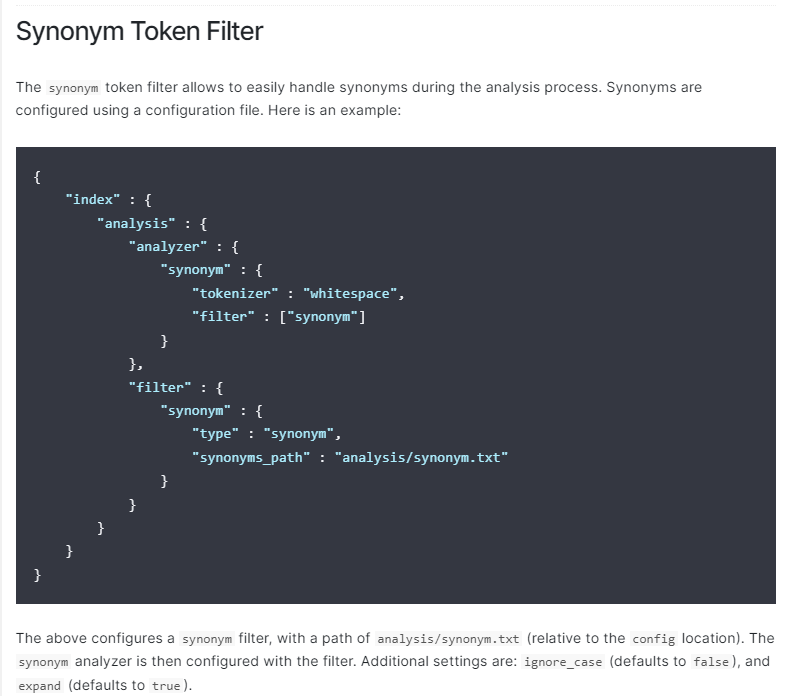

... So I will need two files
* config 
* synonym.txt

### Two Synonym Formats are Supported
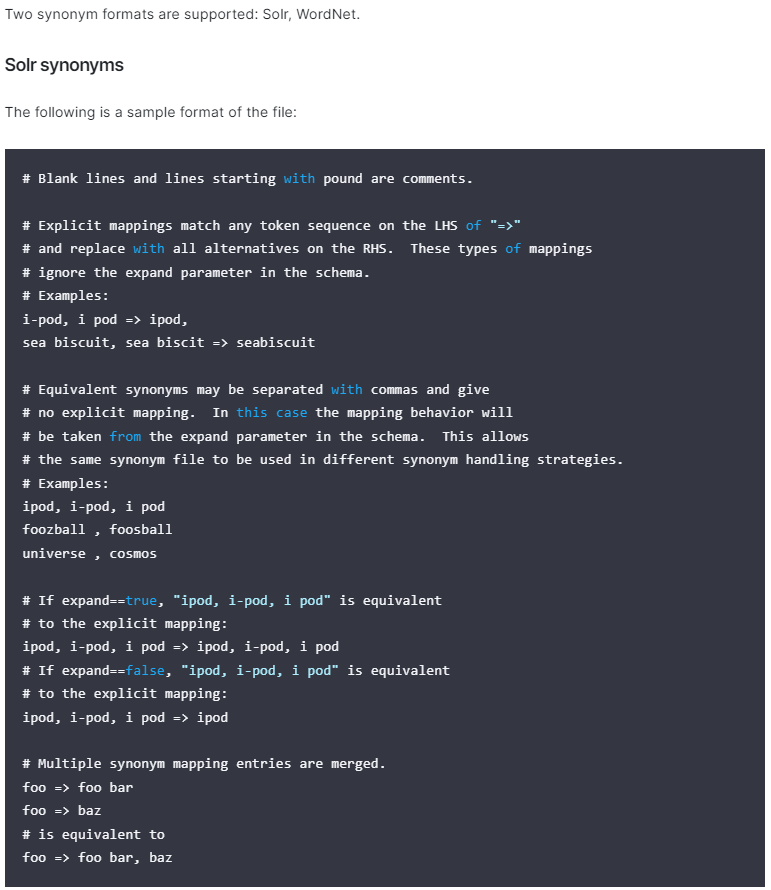
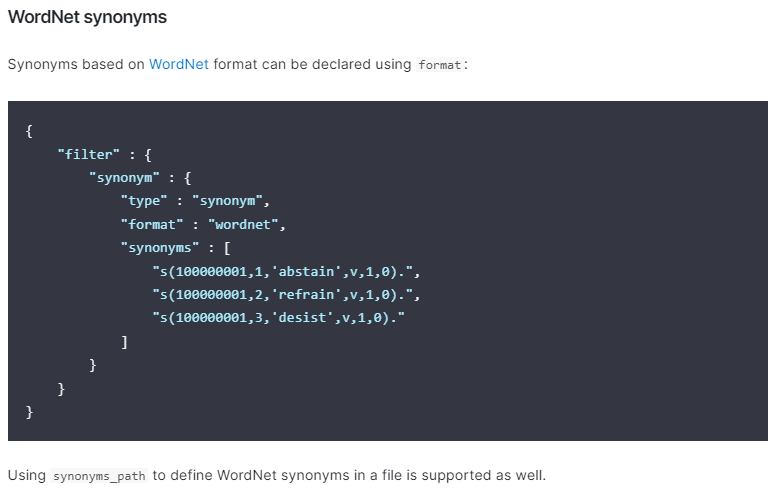

I will be using Solr synonyms in the Equivalent synonym format separated with commas (as all our synonyms we are concerned with as celestial / space objects (confusing nouns that can be represented by multi-word common names and IDs)

# START BUILDING!

### What are some details we need to consider:
* The filter must allow (for example) the following searches to return the same results (these are all searching for Andromeda Galaxy)
    * "m 31"
    * "m31"
    * "M-31"
    * "Andromeda Galaxy"
    * "NGC 224"
    * ... etc ...

* So that means we need to have the following in place:
    * case standardization (`"filter":["lowercase"]`)
    * delimination standardization (remove hyphens and recognize all alpha-numeric words the same way, even if there are spaces, and find a way tokenize common names which will typically be comprised of multiple words seperated with a space...)
        * One approach to delimination standardization would be to leverage the word deliminator features in Elastisearch (like `split_on_numerics`)
        * A second approach would be to expand the selected aliases into the "i pod" example... (the equivelent listing of `i-pod, i pod, ipod` in a `synonym.txt` file... I would opt for this approach... but probably should double check the configuration of AstroBin Elasticsearch.)

* Additionally we will need to focus in on the the pertinent objects from the title data


In [20]:
import pandas as pd

#Homemade methods and classes (includes astropy tools, not written by me)
import methods_and_classes.soam_class as soam
from  methods_and_classes.simbad_alias_search import online_alias_search

In [21]:
#df to hold all the title data (to be used to help focus our synonym filter file)
df = pd.read_csv("data/astrobin_titles_to_subject_types.csv") #the main starting data frame
df.sample(10)

,title,subject_type,solar_system_main_subject
203917,Happy Easter,SOLAR_SYSTEM,MOON
409075,"NGC 6888, Crescent Nebula (with the ""Soap Bubb...",DEEP_SKY,NaN
348301,NGC 4559 and at least 40 other galaxies,DEEP_SKY,NaN
124437,Sun FD in CaK 14th of March 2022 - Colorized,SOLAR_SYSTEM,SUN
597563,DRACO TRIPLET LRG(syntetic)B [NGC 5981 5982 5...,DEEP_SKY,NaN
197455,Cassiopee - Nébuleuse du Coeur et nébuleuse de...,WIDE_FIELD,NaN
337241,M20 TRIFIDE APN 20190704,DEEP_SKY,NaN
569625,Wiedfield of NGC700,DEEP_SKY,NaN
599870,Jupiter du 09/11/2011 22:15 TU,DEEP_SKY,NaN
392852,NOAA12699 White Light Feb 08 2018,SOLAR_SYSTEM,SUN


In [22]:
#Now we will want a Space Object Alias Map (We will use one that we made in the 'building_the_soam.ipynb')
cleaned_soam = soam.Soam()
cleaned_soam.import_soam(file_name="soam_cleaned_bulk_export")
print(cleaned_soam)

#... to get all names listed in the SOAM use...
# cleaned_soam.all_names()

SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"
25631 names / aliases mapped across 4264 objects.


In [23]:
#quick clean the title data
df['cleaned_title'] = df['title'].astype(str).apply(soam.provided_cleaning_method)

In [24]:
#collect all names from the title data (would also work with uncleaned titles as well...)
df['all_names_and_ids'] = df['cleaned_title'].apply(cleaned_soam.find_all_names)

In [25]:
#expand all name lists into individual rows then put them all into a set (removing duplicates)
all_title_names = set(df['all_names_and_ids'].explode())
all_title_names = {str(name) for name in all_title_names} #then cast all items in the set as a str

In [26]:
#ignore all len(name) < 2
#ignore all len(name) <= 3, unless...
#  ... name[0] in [m, c, i, n, s]
#ignore all name[0].isdigit() 
#

all_title_names = {
    name
    for name in all_title_names
    if len(name) >= 2 and 
    (len(name) > 3 or name[0] in ['m', 'c', 'i', 'n', 's']) and 
    not name[0].isdigit()
}

In [27]:
#we should probably avoid "c " containing ids that are also found in the GEAR category
s = "c "
gear_c_ids = set(df[(df['subject_type'] == 'GEAR') & (df['cleaned_title'].str.contains(s))]['all_names_and_ids'].explode())
gear_c_ids = {str(name) for name in gear_c_ids}
gear_c_ids = {ignore_id for ignore_id in gear_c_ids if ignore_id[0] == 'c'}

#removing title names that match the gear names
all_title_names = {name for name in all_title_names if name not in gear_c_ids}

#... and do the same for 'eyes'
all_title_names = {name for name in all_title_names if name != 'eyes'}

In [28]:
# additional removals should include
# ... ignoring the "mm "
all_title_names = {name for name in all_title_names if 'mm ' not in name}
#... others ?

In [29]:
#using the cleaned_soam and all_title_names identified, make a simple_soam

#first, trim out all names from the soam that were not found in the title data
soam_names = {key: value for key, value in cleaned_soam.all_names().items() if key in all_title_names} 

#now there are two choices:

#Choice 1) associate only the names found in title data which share a cleaned_soam alias key
aliases = {}
for key,value in soam_names.items():
    #print(str(key) +" : "+str(value))
    if value in aliases:
        aliases[value].add(key)
    else:
        aliases[value] = {key}
astrobin_associations = [list(alias_set) for alias_set in aliases.values()] #if len(alias_set) > 1]

#Choice 2) associate all names found in title data which share a cleaned_soam alias key 
#             AND build some rules to also pull certain aliases from the corresponding alias set
# ... NOT IMPLEMENTING CHOICE 2, Choice 1 is enough...

In [30]:
# Now again, we have more choices

#Choice 1) leave astrobin_associations as is and build a new astrobin_soam
# ... NOT IMPLEMENTING CHOICE 1, we can do more...

#Choice 2) modify the astrobin_associations to account for variations of id conventions
#      ... Example: 
#          'm 1', 'messier 1', 'm1', 'm-1'
#          'ngc 1952',
#          'sh 2 244', 'sharpless 244'
# ... NOT IMPLEMENTING CHOICE 2, 
#    the hyphen and spacing variations could be handeled by a word delimination token filter...
#    
#Choice 3) modify the astrobin_associations to only simply expand catelog IDs into their written names
#      ... Example: 
#          'm 1', 'messier 1'
#          'ngc 1952',
#          'sh 2 244', 'sharpless 244'
# ... So we could simply make some rules:
# 'sh 2 ' => sharpless
# 'm ' => messier
# 'c ' => caldwell

#PROCEEDING WITH Choice 3)
import re
def replace_substrings(names, rule_dict):
    expanded_names = set()
    for name in names:
        for key, value in rule_dict.items():
            # Use regular expressions with word boundaries to match whole words
            pattern = re.compile(r'\b' + re.escape(key) + r'\b')           
            # Replace only if the key is a whole word (not part of a larger word)
            full_name = pattern.sub(value, name)            
            # Replace only if the value is a whole word (not part of a larger word)
            id_name = pattern.sub(key, name)            
            # Add the fully replaced name and id_name to the set
            expanded_names.add(full_name)
            expanded_names.add(id_name)
    # Convert the set to a list and return the result
    return list(expanded_names)

rule_dict = {
    'sh 2 ': 'sharpless ',
    'm ': 'messier ',
    'c ': 'caldwell '
}

expanded_associations = []
for association in astrobin_associations:
    expanded_associations.append(replace_substrings(association, rule_dict))

In [31]:
#and of course we are only interested in the associations that have two or more items associated
#   (ignore the associations of one item...)
final_associations = [alias_set for alias_set in expanded_associations if len(alias_set) > 1]


In [32]:
#Now we want to export the associations into a solr formated txt file
# -- so, [['messier 2', 'ngc 7089', 'm 2', 'gcl 121'],['messier 95', 'm 95', 'ngc 3351']] 
#    ... gets writen out as ...
#       messier 2, ngc 7089, m 2, gcl 121
#       messier 95, m 95, ngc 3351
    
filename = 'data/astrononimcal_synonyms_030825.txt'
# Open the file in write mode
with open(filename, 'w') as file:
    # Iterate over each nested list
    for associations in final_associations:
        # Join the names in the nested list with ", " and write to the file
        file.write(', '.join(associations) + '\n')



# Additional Notes

## Python Elasticsearch
* https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-synonym-tokenfilter.html 
* https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-word-delimiter-tokenfilter.html
* https://stackoverflow.com/questions/42484892/elasticsearch-and-word-delimiter-token-filter
* https://elasticsearch-py.readthedocs.org/en/master/#running-with-aws-elasticsearch-service
* https://medium.com/version-1/synonyms-in-elasticsearch-c527280ba8a5 
* https://www.elastic.co/blog/found-text-analysis-part-1 
* https://github.com/jprante/elasticsearch-analysis-decompound
* https://www.elastic.co/guide/en/elasticsearch/plugins/2.4/analysis-phonetic.html
* https://django-haystack.readthedocs.io/en/master/tutorial.html 
* https://stackoverflow.com/questions/29254643/add-elasticsearch-synonyms-with-django-haystack 
* https://github.com/bennylope/elasticstack/ 
